# 2 MNIST classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

/Users/christinearnoldt/mambaforge/envs/iannwtf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Loading the MNIST dataset

In [2]:
(train_ds,test_ds), ds_info = tfds.load('mnist', split =['train', 'test'], as_supervised = True , with_info = True)

2023-11-19 15:29:28.958677: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 15:29:28.958703: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 15:29:28.958709: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 15:29:28.958747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 15:29:28.958765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/christinearnoldt/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }"""

2023-11-19 15:29:36.091905: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


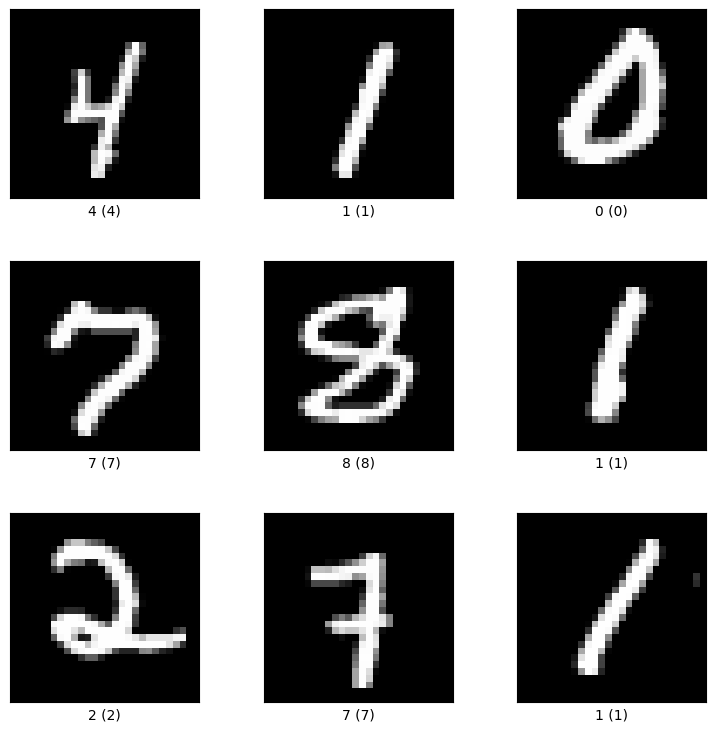

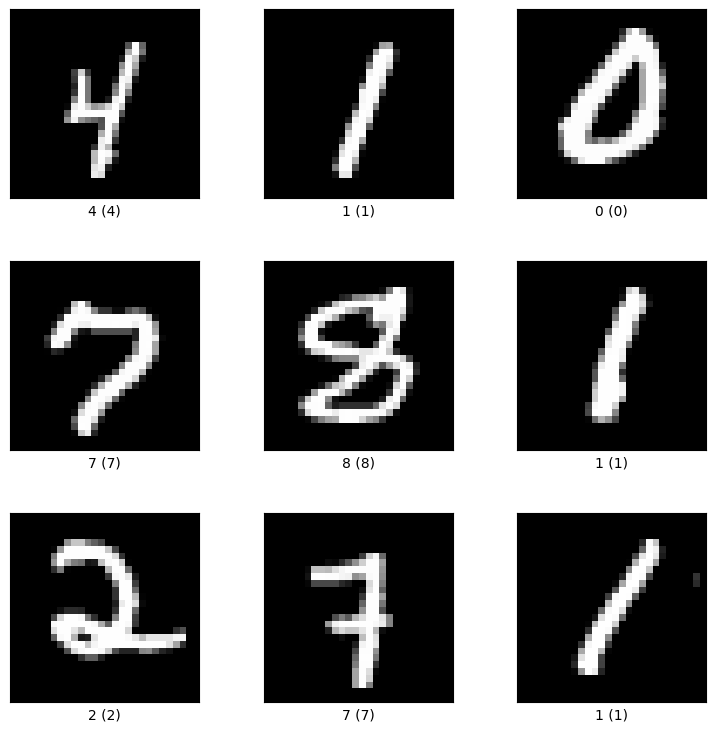

In [4]:
tfds.show_examples(train_ds, ds_info)

### Questions

- How many training/test images are there?
    - There are 60000 training images and 10000 test images.
- What’s the image shape?
    - The shape of each image is (28,28,1).
- What range are pixel values in?
    - The pixels are in uint8 format, meaning they have values in range (0,255)

## 2.2 Setting up the data pipeline

In [5]:
def data_pipeline(ds):
    # flatten image
    ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    # cast values to float values between -1 and 1 (normalization)
    ds = ds.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
    # one hot encode labels
    ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
    return ds

In [8]:
train_ds = data_pipeline(train_ds)
test_ds = data_pipeline(test_ds)

## 2.3 Building a deep neural network with TensorFlow

In [10]:
class MLP_Model(tf.keras.Model):
    def __init__(self, layer_sizes, output_size=10):
        super().__init__()
        self.layers_list = []
        # layer_sizes e.g. [256,256]
        for layer_size in layer_sizes:
            new_layer = tf.keras.layers.Dense(units=layer_size, activation="sigmoid")
            self.layers_list.append(new_layer)
        self.output_layer = tf.keras.layers.Dense(units=output_size, activation="softmax")
        
    def call(self, x):
        for layer in self.layers_list:
            x = layer(x)
        y = self.output_layer(x)
        return y

## 2.4 Training the network

In [11]:
import numpy as np

In [ ]:
def training(epochs, model, train_ds, test_ds, loss_function, optimizer):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        train_loss_epoch = []
        test_loss_epoch = []
        train_accuracy_epoch = []
        test_accuracy_epoch = []
        for x, target in train_ds:
            with tf.GradientTape() as tape: # context manager ('with' opens context)
                pred = model(x)
                train_loss = loss_function(y_true=target, y_pred=pred)
            grad = tape.gradient(train_loss, model.variables)
            optimizer.apply_gradients(zip(grad, model.variables))
            train_loss_epoch.append(train_loss.numpy())
        train_losses.append(np.mean(train_loss_epoch))
    return train_losses, test_losses, train_accuracies, test_accuracies


In [ ]:
training(epochs=10,
         model=MLP_Model(layer_sizes=[256,256]),
         train_ds=train_ds,
         test_ds=test_ds,
         loss_function=tf.keras.losses.CategoricalCrossentropy(),
         optimizer=tf.keras.optimizers.legacy.SGD())

## 2.5 Visualization

In [ ]:
import matplotlib as plt

In [13]:
def visualization (train_losses, train_accuracies, test_losses, test_accuracies):
    """ Visualizes accuracy and loss for training and test data using
        the mean of each epoch.
        
        Loss is displayed in a regular line, accuracy in a dotted line.
        Training data is displayed in blue, test data in red.
    
    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    test_losses : numpy . ndarray
    test losses
    test_accuracies : numpy . ndarray
    test accuracies
    """
    plt.figure ()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(test_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show ()

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)